# Classifiers - NC - low vs mid vs high complexity - no TFv1
Exploring different classifiers with different autoencoders for the NC task. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
#         if cog_res['task_complexity'][task_num_table] == 'medium':
#             continue

        if cog_res['task_label'][task_num_table] != 'NC':
            continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }

        
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=10):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 5, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 5, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

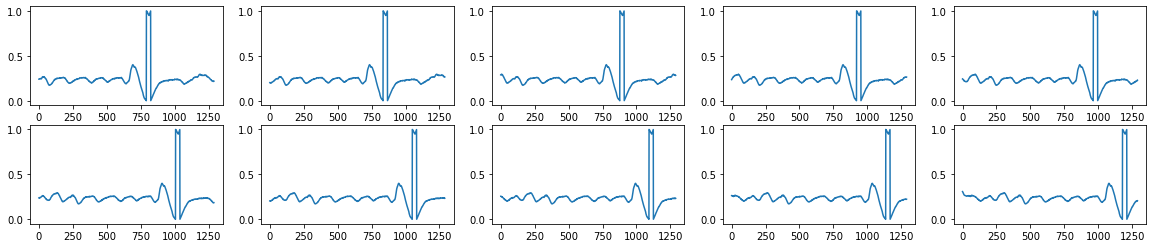

<Figure size 432x288 with 0 Axes>

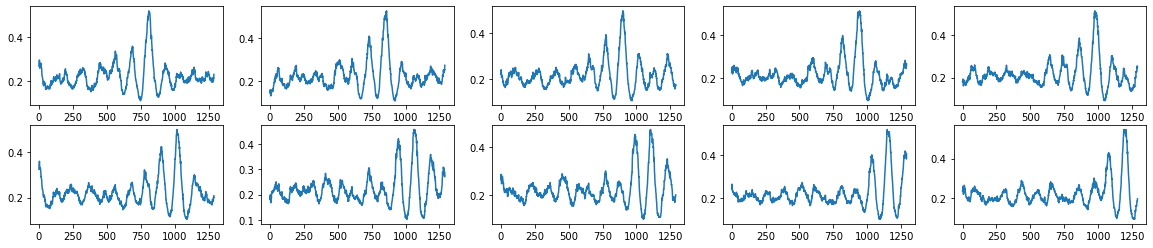

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

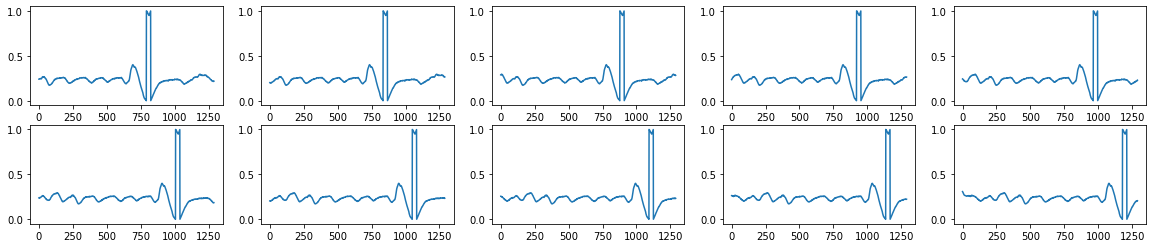

<Figure size 432x288 with 0 Axes>

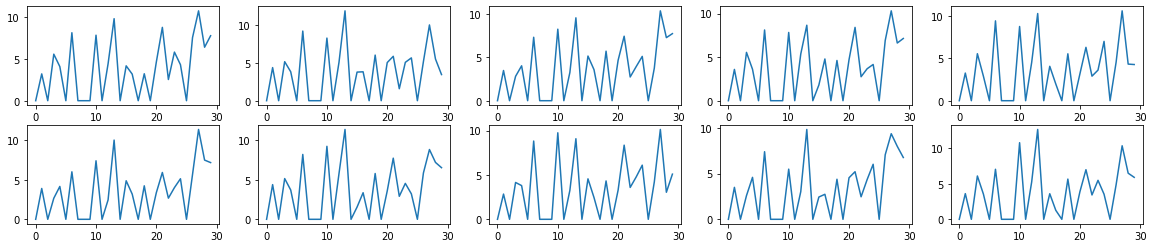

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

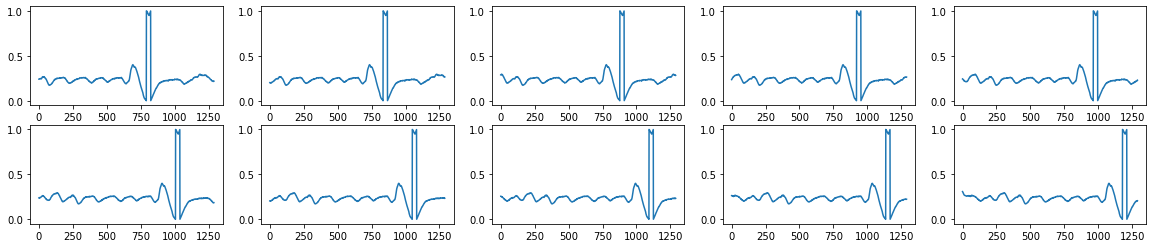

<Figure size 432x288 with 0 Axes>

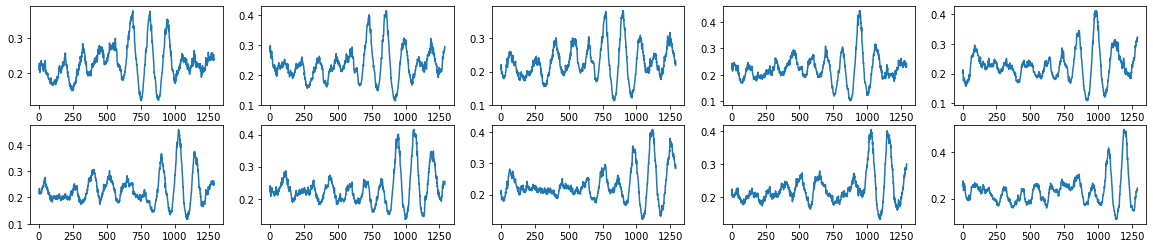

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

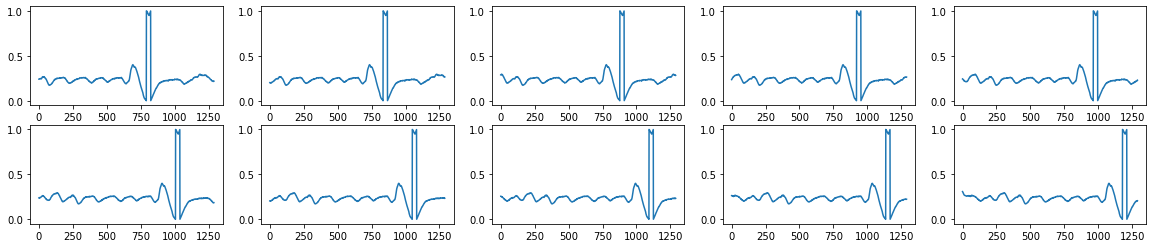

<Figure size 432x288 with 0 Axes>

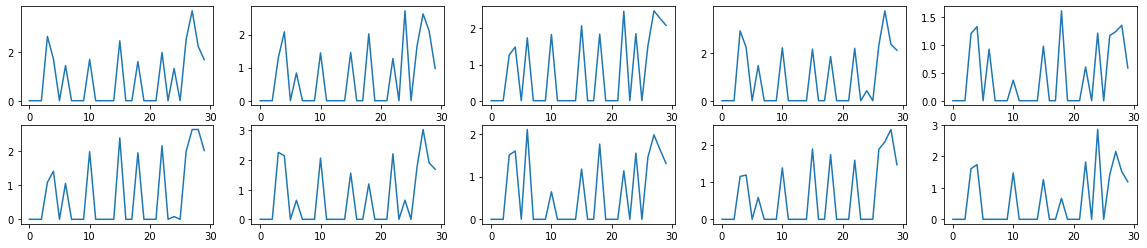

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

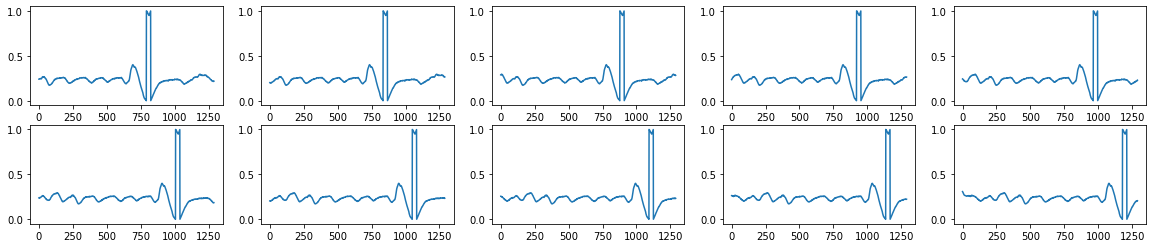

<Figure size 432x288 with 0 Axes>

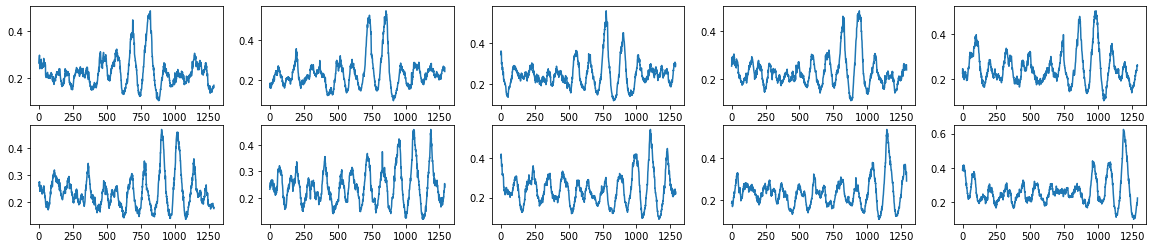

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

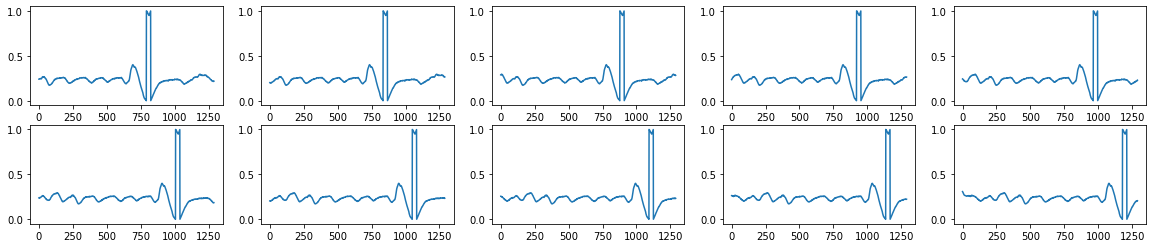

<Figure size 432x288 with 0 Axes>

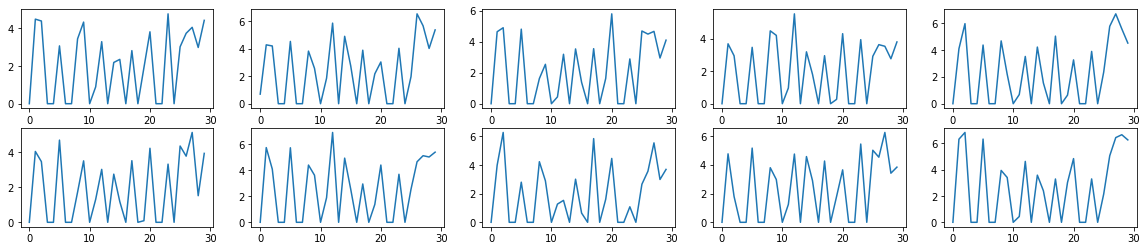

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [33]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [34]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'categorical_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [35]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(3))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [36]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:32.901164
iteration: 3 of 23 ; time elapsed: 0:01:01.560094
iteration: 4 of 23 ; time elapsed: 0:01:33.520784
iteration: 5 of 23 ; time elapsed: 0:02:11.884013
iteration: 6 of 23 ; time elapsed: 0:02:48.483142
iteration: 7 of 23 ; time elapsed: 0:03:54.423155
iteration: 8 of 23 ; time elapsed: 0:04:34.398573
iteration: 9 of 23 ; time elapsed: 0:05:11.467564
iteration: 10 of 23 ; time elapsed: 0:05:44.023869
iteration: 11 of 23 ; time elapsed: 0:06:21.191619
iteration: 12 of 23 ; time elapsed: 0:06:57.028082
iteration: 13 of 23 ; time elapsed: 0:07:26.735266
iteration: 14 of 23 ; time elapsed: 0:07:59.245853
iteration: 15 of 23 ; time elapsed: 0:08:29.243113
iteration: 16 of 23 ; time elapsed: 0:09:02.342536
iteration: 17 of 23 ; time elapsed: 0:09:34.869038
iteration: 18 of 23 ; time elapsed: 0:10:05.926847
iteration: 19 of 23 ; time elapsed: 0:10:39.227022
iteration: 20 of 23 ; time elapsed: 0:11:09.256

In [37]:
accuracies['simple_dense'] = accs

In [38]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.433333,0.733333,0.400000,0.533333,0.333333,0.400000,0.466667,62i9y
1,0.400000,0.366667,0.233333,0.500000,0.266667,0.200000,0.233333,2gu87
2,0.266667,0.666667,0.666667,0.666667,0.233333,0.566667,0.333333,iz2ps
3,0.200000,0.333333,0.166667,0.033333,0.000000,0.000000,0.233333,1mpau
4,0.266667,0.300000,0.466667,0.566667,0.366667,0.066667,0.166667,7dwjy
5,0.666667,0.300000,0.433333,0.333333,0.666667,0.500000,0.166667,7swyk
6,0.366667,0.500000,0.133333,0.200000,0.000000,0.333333,0.666667,94mnx
7,0.000000,0.333333,0.533333,0.533333,0.233333,0.300000,0.333333,bd47a
8,0.500000,0.200000,0.333333,0.333333,0.500000,0.800000,0.666667,c24ur
9,0.433333,0.600000,0.000000,0.333333,0.666667,0.166667,0.100000,ctsax


In [39]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.100000   0.000000        0.000000       0.000000  0.000000  0.100000
max     0.666667   0.766667   0.666667        0.833333       0.666667  0.800000  0.733333
mean    0.359420   0.386957   0.342029        0.394203       0.340580  0.360870  0.336232
median  0.366667   0.333333   0.366667        0.333333       0.333333  0.333333  0.333333


#### LSTM-based classifier  
based on the original author's code

In [40]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [41]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [42]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [43]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(3))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [44]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:34.218925
iteration: 3 of 23 ; time elapsed: 0:03:11.060335
iteration: 4 of 23 ; time elapsed: 0:05:04.803742
iteration: 5 of 23 ; time elapsed: 0:07:11.731361
iteration: 6 of 23 ; time elapsed: 0:09:08.736885
iteration: 7 of 23 ; time elapsed: 0:11:00.240017
iteration: 8 of 23 ; time elapsed: 0:12:40.310390
iteration: 9 of 23 ; time elapsed: 0:14:13.706508
iteration: 10 of 23 ; time elapsed: 0:15:50.305726
iteration: 11 of 23 ; time elapsed: 0:17:24.300243
iteration: 12 of 23 ; time elapsed: 0:18:58.161117
iteration: 13 of 23 ; time elapsed: 0:20:28.845489
iteration: 14 of 23 ; time elapsed: 0:21:58.590377
iteration: 15 of 23 ; time elapsed: 0:23:31.383109
iteration: 16 of 23 ; time elapsed: 0:25:02.131313
iteration: 17 of 23 ; time elapsed: 0:26:38.679994
iteration: 18 of 23 ; time elapsed: 0:28:11.330110
iteration: 19 of 23 ; time elapsed: 0:29:39.893157
iteration: 20 of 23 ; time elapsed: 0:31:10.352

In [45]:
accuracies['LSTM'] = accs

In [46]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.100000,0.666667,0.266667,0.300000,0.333333,0.333333,0.333333,62i9y
1,0.666667,0.500000,0.200000,0.566667,0.266667,0.300000,0.600000,2gu87
2,0.233333,0.566667,0.766667,0.200000,0.333333,0.266667,0.333333,iz2ps
3,0.333333,0.300000,0.133333,0.533333,0.000000,0.333333,0.333333,1mpau
4,0.266667,0.666667,0.466667,0.466667,0.200000,0.266667,0.333333,7dwjy
5,0.600000,0.366667,0.566667,0.300000,0.700000,0.433333,0.333333,7swyk
6,0.266667,0.500000,0.266667,0.033333,0.066667,0.000000,0.333333,94mnx
7,0.333333,0.433333,0.533333,0.333333,0.166667,0.200000,0.333333,bd47a
8,0.333333,0.366667,0.266667,0.333333,0.566667,0.600000,0.366667,c24ur
9,0.333333,0.300000,0.433333,0.733333,0.666667,0.300000,0.333333,ctsax


In [47]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.100000   0.033333   0.033333        0.033333       0.000000  0.000000  0.033333
max     0.666667   0.666667   0.766667        0.733333       0.800000  0.633333  0.633333
mean    0.353623   0.411594   0.378261        0.368116       0.318841  0.346377  0.357971
median  0.333333   0.433333   0.400000        0.333333       0.333333  0.333333  0.333333


#### kNN

In [48]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [49]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [50]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [52]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = OneVsRestClassifier(KNN_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.154128
iteration: 3 of 23 ; time elapsed: 0:00:00.298749
iteration: 4 of 23 ; time elapsed: 0:00:00.439401
iteration: 5 of 23 ; time elapsed: 0:00:00.585013
iteration: 6 of 23 ; time elapsed: 0:00:00.731338
iteration: 7 of 23 ; time elapsed: 0:00:00.877968
iteration: 8 of 23 ; time elapsed: 0:00:01.024089
iteration: 9 of 23 ; time elapsed: 0:00:01.166707
iteration: 10 of 23 ; time elapsed: 0:00:01.309341
iteration: 11 of 23 ; time elapsed: 0:00:01.451959
iteration: 12 of 23 ; time elapsed: 0:00:01.611072
iteration: 13 of 23 ; time elapsed: 0:00:01.772188
iteration: 14 of 23 ; time elapsed: 0:00:01.944237
iteration: 15 of 23 ; time elapsed: 0:00:02.107344
iteration: 16 of 23 ; time elapsed: 0:00:02.274394
iteration: 17 of 23 ; time elapsed: 0:00:02.437524
iteration: 18 of 23 ; time elapsed: 0:00:02.595137
iteration: 19 of 23 ; time elapsed: 0:00:02.753197
iteration: 20 of 23 ; time elapsed: 0:00:02.908

In [54]:
accuracies['kNN'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.300000,0.533333,0.033333,0.400000,0.266667,0.500000,0.233333,62i9y
1,0.466667,0.633333,0.366667,0.566667,0.166667,0.333333,0.133333,2gu87
2,0.666667,0.400000,0.300000,0.333333,0.266667,0.566667,0.566667,iz2ps
3,0.133333,0.266667,0.200000,0.133333,0.133333,0.333333,0.166667,1mpau
4,0.400000,0.533333,0.833333,0.600000,0.000000,0.100000,0.066667,7dwjy
5,0.500000,0.366667,0.666667,0.366667,0.566667,0.300000,0.266667,7swyk
6,0.800000,0.433333,0.233333,0.200000,0.366667,0.366667,0.366667,94mnx
7,0.600000,0.266667,0.300000,0.400000,0.200000,0.200000,0.300000,bd47a
8,0.666667,0.266667,0.400000,0.633333,0.400000,0.600000,0.733333,c24ur
9,0.266667,0.633333,0.166667,0.366667,0.600000,0.433333,0.433333,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.100000   0.000000   0.033333        0.133333       0.000000  0.100000  0.066667
max     0.800000   0.700000   0.833333        0.700000       0.666667  0.600000  0.733333
mean    0.428986   0.371014   0.342029        0.382609       0.318841  0.315942  0.334783
median  0.400000   0.366667   0.300000        0.333333       0.333333  0.333333  0.333333


####  SVC

In [57]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [58]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [59]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [60]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [61]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = OneVsRestClassifier(SVC_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [62]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:02.095094
iteration: 3 of 23 ; time elapsed: 0:00:04.212313
iteration: 4 of 23 ; time elapsed: 0:00:06.312464
iteration: 5 of 23 ; time elapsed: 0:00:08.345352
iteration: 6 of 23 ; time elapsed: 0:00:10.502984
iteration: 7 of 23 ; time elapsed: 0:00:12.744267
iteration: 8 of 23 ; time elapsed: 0:00:15.018840
iteration: 9 of 23 ; time elapsed: 0:00:17.201071
iteration: 10 of 23 ; time elapsed: 0:00:19.503941
iteration: 11 of 23 ; time elapsed: 0:00:21.760036
iteration: 12 of 23 ; time elapsed: 0:00:24.079250
iteration: 13 of 23 ; time elapsed: 0:00:26.314646
iteration: 14 of 23 ; time elapsed: 0:00:28.310626
iteration: 15 of 23 ; time elapsed: 0:00:30.108240
iteration: 16 of 23 ; time elapsed: 0:00:31.948648
iteration: 17 of 23 ; time elapsed: 0:00:33.758536
iteration: 18 of 23 ; time elapsed: 0:00:35.546915
iteration: 19 of 23 ; time elapsed: 0:00:37.352684
iteration: 20 of 23 ; time elapsed: 0:00:39.109

In [63]:
accuracies['SVC'] = accs

In [64]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.466667,0.666667,0.133333,0.600000,0.400000,0.433333,0.300000,62i9y
1,0.266667,0.500000,0.466667,0.500000,0.500000,0.400000,0.133333,2gu87
2,0.300000,0.400000,0.500000,0.300000,0.333333,0.133333,0.233333,iz2ps
3,0.066667,0.066667,0.166667,0.033333,0.033333,0.100000,0.233333,1mpau
4,0.033333,0.533333,0.733333,0.666667,0.200000,0.200000,0.000000,7dwjy
5,0.400000,0.333333,0.666667,0.333333,0.333333,0.400000,0.333333,7swyk
6,0.366667,0.500000,0.133333,0.133333,0.233333,0.333333,0.333333,94mnx
7,0.100000,0.433333,0.566667,0.433333,0.066667,0.300000,0.233333,bd47a
8,0.300000,0.366667,0.466667,0.233333,0.233333,0.533333,0.500000,c24ur
9,0.300000,0.633333,0.166667,0.333333,0.266667,0.500000,0.466667,ctsax


In [65]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.033333   0.033333   0.033333        0.033333       0.033333  0.066667  0.000000
max     0.700000   0.933333   0.766667        0.733333       0.500000  0.700000  0.800000
mean    0.339130   0.382609   0.398551        0.366667       0.330435  0.368116  0.388406
median  0.333333   0.400000   0.433333        0.333333       0.333333  0.400000  0.366667


#### Random Forest

In [66]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [67]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [68]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [69]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [70]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = OneVsRestClassifier(random_forest_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:09.701463
iteration: 3 of 23 ; time elapsed: 0:00:19.170017
iteration: 4 of 23 ; time elapsed: 0:00:28.728565
iteration: 5 of 23 ; time elapsed: 0:00:38.134182
iteration: 6 of 23 ; time elapsed: 0:00:47.653248
iteration: 7 of 23 ; time elapsed: 0:00:57.227664
iteration: 8 of 23 ; time elapsed: 0:01:06.708676
iteration: 9 of 23 ; time elapsed: 0:01:16.247759
iteration: 10 of 23 ; time elapsed: 0:01:26.185465
iteration: 11 of 23 ; time elapsed: 0:01:36.119896
iteration: 12 of 23 ; time elapsed: 0:01:46.249002
iteration: 13 of 23 ; time elapsed: 0:01:56.119175
iteration: 14 of 23 ; time elapsed: 0:02:05.822750
iteration: 15 of 23 ; time elapsed: 0:02:15.199003
iteration: 16 of 23 ; time elapsed: 0:02:24.739863
iteration: 17 of 23 ; time elapsed: 0:02:34.731704
iteration: 18 of 23 ; time elapsed: 0:02:44.915962
iteration: 19 of 23 ; time elapsed: 0:02:54.603908
iteration: 20 of 23 ; time elapsed: 0:03:04.342

In [72]:
accuracies['random_forest'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.566667,0.200000,0.200000,0.266667,0.300000,0.333333,62i9y
1,0.333333,0.466667,0.400000,0.500000,0.066667,0.333333,0.200000,2gu87
2,0.333333,0.400000,0.300000,0.466667,0.633333,0.533333,0.700000,iz2ps
3,0.333333,0.233333,0.233333,0.066667,0.000000,0.000000,0.133333,1mpau
4,0.300000,0.500000,0.666667,0.700000,0.666667,0.200000,0.000000,7dwjy
5,0.566667,0.366667,0.533333,0.366667,0.533333,0.500000,0.433333,7swyk
6,0.333333,0.500000,0.266667,0.200000,0.166667,0.333333,0.366667,94mnx
7,0.100000,0.500000,0.500000,0.433333,0.100000,0.066667,0.133333,bd47a
8,0.666667,0.200000,0.466667,0.400000,0.400000,0.566667,0.300000,c24ur
9,0.333333,0.233333,0.133333,0.200000,0.366667,0.333333,0.333333,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.000000   0.100000        0.000000       0.000000  0.000000  0.000000
max     0.666667   0.666667   0.833333        0.900000       0.700000  0.800000  0.700000
mean    0.365217   0.404348   0.384058        0.407246       0.331884  0.320290  0.291304
median  0.333333   0.433333   0.333333        0.366667       0.333333  0.333333  0.333333


#### Naive Bayesian

In [75]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [76]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(naive_bayesian_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [77]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.121212
iteration: 3 of 23 ; time elapsed: 0:00:00.239894
iteration: 4 of 23 ; time elapsed: 0:00:00.352564
iteration: 5 of 23 ; time elapsed: 0:00:00.471639
iteration: 6 of 23 ; time elapsed: 0:00:00.584371
iteration: 7 of 23 ; time elapsed: 0:00:00.702087
iteration: 8 of 23 ; time elapsed: 0:00:00.819772
iteration: 9 of 23 ; time elapsed: 0:00:00.937969
iteration: 10 of 23 ; time elapsed: 0:00:01.060914
iteration: 11 of 23 ; time elapsed: 0:00:01.176114
iteration: 12 of 23 ; time elapsed: 0:00:01.291988
iteration: 13 of 23 ; time elapsed: 0:00:01.416835
iteration: 14 of 23 ; time elapsed: 0:00:01.538493
iteration: 15 of 23 ; time elapsed: 0:00:01.655209
iteration: 16 of 23 ; time elapsed: 0:00:01.768905
iteration: 17 of 23 ; time elapsed: 0:00:01.883570
iteration: 18 of 23 ; time elapsed: 0:00:02.000286
iteration: 19 of 23 ; time elapsed: 0:00:02.123957
iteration: 20 of 23 ; time elapsed: 0:00:02.239

In [78]:
accuracies['naive_bayesian'] = accs

In [79]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.333333,0.333333,0.233333,0.500000,0.333333,0.333333,0.166667,62i9y
1,0.333333,0.366667,0.166667,0.333333,0.400000,0.500000,0.400000,2gu87
2,0.333333,0.000000,0.333333,0.033333,0.333333,0.000000,0.333333,iz2ps
3,0.333333,0.066667,0.000000,0.033333,0.000000,0.000000,0.000000,1mpau
4,0.666667,0.333333,0.366667,0.000000,0.000000,0.233333,0.333333,7dwjy
5,0.333333,0.333333,0.633333,0.333333,0.333333,0.666667,0.333333,7swyk
6,0.333333,0.266667,0.066667,0.333333,0.166667,0.000000,0.633333,94mnx
7,0.333333,0.333333,0.566667,0.333333,0.000000,0.166667,0.333333,bd47a
8,0.666667,0.700000,0.233333,0.666667,0.633333,0.666667,0.666667,c24ur
9,0.000000,0.633333,0.166667,0.300000,0.333333,0.333333,0.000000,ctsax


In [80]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.000000   0.000000        0.000000       0.000000  0.000000  0.000000
max     0.666667   0.700000   0.633333        0.666667       0.666667  0.666667  0.666667
mean    0.339130   0.356522   0.292754        0.328986       0.304348  0.308696  0.307246
median  0.333333   0.333333   0.266667        0.333333       0.333333  0.333333  0.333333


#### XGBoost

In [81]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [82]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [83]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [84]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [85]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = OneVsRestClassifier(XGBoost_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [86]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:05.217812
iteration: 3 of 23 ; time elapsed: 0:00:10.137946
iteration: 4 of 23 ; time elapsed: 0:00:14.590779
iteration: 5 of 23 ; time elapsed: 0:00:18.988882
iteration: 6 of 23 ; time elapsed: 0:00:23.307812
iteration: 7 of 23 ; time elapsed: 0:00:27.686347
iteration: 8 of 23 ; time elapsed: 0:00:32.072212
iteration: 9 of 23 ; time elapsed: 0:00:36.544476
iteration: 10 of 23 ; time elapsed: 0:00:40.959087
iteration: 11 of 23 ; time elapsed: 0:00:45.352619
iteration: 12 of 23 ; time elapsed: 0:00:49.798301
iteration: 13 of 23 ; time elapsed: 0:00:54.309091
iteration: 14 of 23 ; time elapsed: 0:00:58.874037
iteration: 15 of 23 ; time elapsed: 0:01:03.242938
iteration: 16 of 23 ; time elapsed: 0:01:07.741729
iteration: 17 of 23 ; time elapsed: 0:01:12.083293
iteration: 18 of 23 ; time elapsed: 0:01:17.248329
iteration: 19 of 23 ; time elapsed: 0:01:22.135050
iteration: 20 of 23 ; time elapsed: 0:01:27.041

In [87]:
accuracies['XGBoost'] = accs

In [88]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.366667,0.566667,0.233333,0.200000,0.266667,0.366667,0.466667,62i9y
1,0.333333,0.466667,0.366667,0.500000,0.233333,0.300000,0.366667,2gu87
2,0.566667,0.533333,0.333333,0.533333,0.600000,0.566667,0.333333,iz2ps
3,0.500000,0.066667,0.166667,0.200000,0.100000,0.066667,0.233333,1mpau
4,0.300000,0.533333,0.633333,0.766667,0.500000,0.233333,0.133333,7dwjy
5,0.533333,0.433333,0.366667,0.433333,0.566667,0.466667,0.466667,7swyk
6,0.500000,0.366667,0.166667,0.100000,0.233333,0.333333,0.366667,94mnx
7,0.200000,0.433333,0.533333,0.433333,0.233333,0.166667,0.233333,bd47a
8,0.566667,0.266667,0.466667,0.533333,0.366667,0.333333,0.266667,c24ur
9,0.566667,0.033333,0.333333,0.500000,0.333333,0.366667,0.333333,ctsax


In [89]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.033333   0.100000        0.033333       0.000000  0.000000  0.000000
max     0.633333   0.633333   0.766667        0.866667       0.666667  0.666667  0.633333
mean    0.360870   0.400000   0.389855        0.453623       0.343478  0.321739  0.315942
median  0.366667   0.433333   0.366667        0.500000       0.333333  0.333333  0.333333


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [90]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.100000   0.000000        0.000000       0.000000  0.000000  0.100000
max     0.666667   0.766667   0.666667        0.833333       0.666667  0.800000  0.733333
mean    0.359420   0.386957   0.342029        0.394203       0.340580  0.360870  0.336232
median  0.366667   0.333333   0.366667        0.333333       0.333333  0.333333  0.333333


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.100000   0.033333   0.033333        0.033333       0.000000  0.000000  0.033333
max     0.666667   0.666667   0.766667        0.733333       0.800000  0.633333  0.633333
mean    0.353623   0.411594   0.378261        0.368116       0.318841  0.346377  0.357971
median  0.333333   0.433333   0.400000        0.333333       0.333333  0.333333  0.333333


----------- kNN: -----------

Print all accuracies in table form:

In [91]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.433333   0.733333   0.400000        0.533333       0.333333  0.400000  0.466667   62i9y
1   0.400000   0.366667   0.233333        0.500000       0.266667  0.200000  0.233333   2gu87
2   0.266667   0.666667   0.666667        0.666667       0.233333  0.566667  0.333333   iz2ps
3   0.200000   0.333333   0.166667        0.033333       0.000000  0.000000  0.233333   1mpau
4   0.266667   0.300000   0.466667        0.566667       0.366667  0.066667  0.166667   7dwjy
5   0.666667   0.300000   0.433333        0.333333       0.666667  0.500000  0.166667   7swyk
6   0.366667   0.500000   0.133333        0.200000       0.000000  0.333333  0.666667   94mnx
7   0.000000   0.333333   0.533333        0.533333       0.233333  0.300000  0.333333   bd47a
8   0.500000   0.200000   0.333333        0.333333       0.500000  0.800000  0.666667   c24ur
9   0.433333   0.600000   0.000000        0.33